<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

# Softmax regression

In this exercise you will train a softmax regression model to recognize handwritten digits.
  
The general setup is as follows:
* we are given a set of pairs $(x, y)$, where $x \in R^D$ is a vector of real numbers representing the features, and $y \in \{1,...,c\}$ is the target (in our case we have ten classes, so $c=10$),
* for a given $x$ we model the probability of $y=j$ by $$h(x)_j=p_j = \frac{e^{w_j^Tx}}{\sum_{i=1}^c e^{w_i^Tx}},$$
* to find the right $w$ we will optimize the so called multiclass log loss:
$$L(y,p) = \log{p_y},$$
$$J(w) = -\frac{1}{n}\sum_{i=1}^n L(y_i,h(x)),$$
* with the loss function in hand we can improve our guesses iteratively:
    * $w_{ij}^{t+1} = w_{ij}^t - \text{step_size} \cdot \frac{\partial J(w)}{\partial w_{ij}}$,
* we can end the process after some predefined number of epochs (or when the changes are no longer meaningful).

Let's start with importing the MNIST dataset.

In [1]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz
!pip install plotly==5.3.1

--2025-11-01 22:35:55--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.203.145, 16.15.207.138, 54.231.166.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.203.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  61.8MB/s    in 0.2s    

2025-11-01 22:35:56 (61.8 MB/s) - ‘mnist.npz’ saved [11490434/11490434]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [2]:
import numpy as np

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

Let's take a look at the data. In the "x" arrays you'll find the images (encoded as pixel intensities) and in the "y" ones you'll find the labels (one-hot encoded).

In [3]:
print(x_train.shape)
print(y_train.shape)

print(x_train[:10])
print(y_train[:10])

(60000, 784)
(60000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now let us see the data in a more human way.

In [5]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
#import plotly.express as px

num_samples = 10
plots = make_subplots(rows=1, cols=num_samples)

for i in range(num_samples):
  a = x_train[i, :].reshape(28,28)
  img = go.Heatmap(z=a, colorscale='gray')
  plots.add_trace(img, row=1, col=i+1)

plots.update_yaxes(autorange='reversed', scaleanchor='x', constrain='domain')
plots.update_xaxes(constrain='domain')
plots.update_traces(showscale=False)
plots.show()


Next, we prepare $X$ and $y$ variables

In [6]:
X = x_train[:4000]
y = y_train[:4000]

print(X.shape)
print(y.shape)

(4000, 784)
(4000, 10)


To train the model we will (obviously) use gradient descent. Inside the loop we need a method to compute the gradients. Let's start with implementing it, together with some helper functions.


* for a given $x$ we model the probability of $y=j$ by $$h(x)_j=p_j = \frac{e^{w_j^Tx}}{\sum_{i=1}^c e^{w_i^Tx}},$$
* to find the right $w$ we will optimize the so called multiclass log loss:
$$L(y,p) = \log{p_y},$$
$$J(w) = -\frac{1}{n}\sum_{i=1}^n L(y_i,h(x)),$$
* with the loss function in hand we can improve our guesses iteratively:
    * $w_{ij}^{t+1} = w_{ij}^t - \text{step_size} \cdot \frac{\partial J(w)}{\partial w_{ij}}$,

The derivative of the cost function $J(w)$ with respect to the weights $w_{ij}$ is given by:

$$
\frac{\partial J(w)}{\partial w_{ij}} = -\frac{1}{n} \sum_{k=1}^n (y_{ki} - p_{ki}) x_{kj}
$$

where:
- $n$ is the number of training examples.
- $y_{ki}$ is the true label for the $k$-th example and $i$-th class (1 if the $k$-th example belongs to class $i$, 0 otherwise).
- $p_{ki}$ is the predicted probability that the $k$-th example belongs to class $i$, calculated by the softmax function: $p_{ki} = \frac{e^{w_i^Tx_k}}{\sum_{j=1}^c e^{w_j^Tx_k}}$.
- $x_{kj}$ is the $j$-th feature of the $k$-th example.

This derivative tells us how much the cost function changes when we change a specific weight $w_{ij}$. In gradient descent, we update the weights by subtracting a scaled version of the gradient. The goal is to move in the direction that decreases the cost function.

The formula for the derivative arises from applying the chain rule to the cost function $J(w) = -\frac{1}{n}\sum_{k=1}^n \log(p_{ky_k})$. The derivation involves the derivative of the log function and the derivative of the softmax function. The resulting gradient has a simple form: it's the average of the difference between the true labels and the predicted probabilities, scaled by the input features.

In [7]:
# We will store the weights in a D x c matrix, where D is the number of features, and c is the number of classes
#weights = (...) # TODO: Fill in, be sure to have the right shape!
weights = np.zeros([X.shape[1], 10])


def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)


def predict(weights, X):
    return softmax(np.dot(X, weights))

def compute_loss_and_gradients(weights, X, y, l2_reg):
    loss = np.log(predict(weights, X))
    grad = - 1/X.shape[0] * np.dot(X.T, y - predict(weights, X)) + 2 * l2_reg * weights
    return np.mean(loss), grad

We are now in position to complete the training pipeline.

If you have problems with convergence, be sure to check the gradients numerically.

AttributeError: 'PathCollection' object has no attribute 'update_layout'

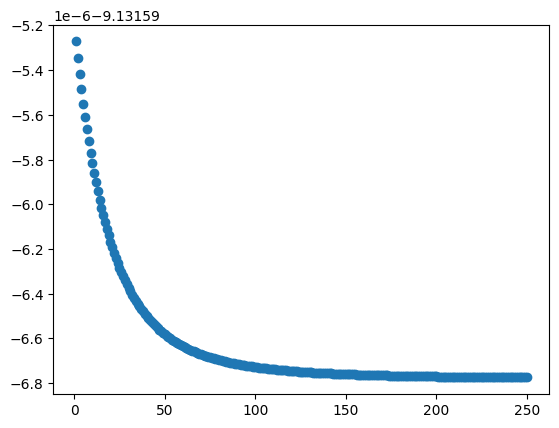

In [11]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

l2_reg = 0.5
n_epochs = 250
lr = 0.05
t = 0.99

losses = []
for i in range(n_epochs):
    loss, grad = compute_loss_and_gradients(weights, X, y, l2_reg)
    losses.append(loss)

    weights -= lr * grad
    lr *= t

fig = go.Figure(data=go.Scatter(x=list(range(1, n_epochs + 1)), y=losses))
fig.update_layout(xaxis_title="Epoch", yaxis_title='Loss')

fig.show()

Now compute your accuracy on the training and test sets.

In [12]:
acc = np.mean(predict(weights, x_train).argmax(axis=1) == y_train.argmax(axis=1))
print("Train accuracy: ", acc)
acc = np.mean(predict(weights, x_test).argmax(axis=1) == y_test.argmax(axis=1))
print("Test accuracy: ", acc)

Train accuracy:  0.6906666666666667
Test accuracy:  0.6829


We can also visualize the weights learned by our algorithm. Try to anticipate the result before executing the cell below.

In [34]:
num_samples = 10
plots = make_subplots(rows=1, cols=num_samples)

for i in range(num_samples):
  a = weights[:, i].reshape(28,28)
  img = go.Heatmap(z=a, colorscale='gray')
  plots.add_trace(img, row=1, col=i+1)

plots.update_yaxes(autorange='reversed', scaleanchor='x', constrain='domain')
plots.update_xaxes(constrain='domain')
plots.update_traces(showscale=False)
plots.show()

Note that we only used a small portion of the data to develop the model. Now, implement the training on full data. Also, validate your model properly and find a good value for `l2_reg` hyperparameter. Try to experiment with `batch_size`.


In [32]:
################################################
# TODO: implement the proper training pipeline #
################################################
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go


weights = np.zeros([x_train.shape[1], 10])

l2_reg = 0.99
n_epochs = 300
lr = 0.05
t = 0.999
batch_size = 1000
losses = []

for i in tqdm(range(n_epochs)):
    batch = np.random.choice(range(0, x_train.shape[0]), batch_size)
    x_batch = x_train[batch]
    y_batch = y_train[batch]
    loss, grad = compute_loss_and_gradients(weights, x_batch, y_batch, l2_reg)
    losses.append(loss)

    weights -= lr * grad
    lr *= t

fig = go.Figure(data=go.Scatter(x=list(range(1, n_epochs + 1)), y=losses))
fig.update_layout(xaxis_title="Epoch", yaxis_title='Loss')

fig.show()

100%|██████████| 300/300 [00:05<00:00, 50.45it/s]


In [33]:
acc = np.mean(predict(weights, x_train).argmax(axis=1) == y_train.argmax(axis=1))
print("Train accuracy: ", acc)
acc = np.mean(predict(weights, x_test).argmax(axis=1) == y_test.argmax(axis=1))
print("Test accuracy: ", acc)

Train accuracy:  0.73385
Test accuracy:  0.7449


<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>